### Урок 5. Сегментация изображений
Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

In [2]:
#!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 2.5 MB/s eta 0:00:00


In [3]:
# Загрузка библиотек

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from PIL import Image
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

In [9]:
# Загрузка данных

csv_path = 'list.csv'
img_path = '720p/'
mask_path = 'mask/'

In [10]:
df = pd.read_csv(csv_path)

imgs_set = set(os.listdir(img_path))
masks_set = set(os.listdir(mask_path))

imgs_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in imgs_set)
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

not_mask = imgs_set.difference(masks_set)

not_mask = [f'image{i}.jpg' for i in not_mask]

df = df.loc[~df['filename'].isin(not_mask)]
df.reset_index(drop=True, inplace=True)

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [11]:
# class CustomDatasetFromImages

class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info: pd.DataFrame, img_path, mask_path, transform=None):
        self.data_info = data_info
        self.data_info['filename'] = self.data_info['filename'].apply(lambda f: os.path.join(img_path, f) if os.path.exists(os.path.join(img_path, f)) else np.NaN)
        self.data_info['mask'] = self.data_info['mask'].apply(lambda f: os.path.join(mask_path, f) if os.path.join(mask_path, f) else np.NaN)
        self.data_info.dropna(axis=0, inplace=True)

        self.img_path = [os.path.join(img_path, image_id) for image_id in sorted(os.listdir(img_path))]
        self.mask_path = [os.path.join(mask_path, image_id) for image_id in sorted(os.listdir(mask_path))]
        self.data_len = len(self.data_info)
        self.transform = transform

    def __getitem__(self, index):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(str(self.data_info.iloc[index]['filename'])), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(str(self.data_info.iloc[index]['mask'])), cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        mask = mask / 255

        image = image.astype('float32')
        mask = mask.astype('float32')

        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image.astype('float32')), transforms.ToTensor()(mask.astype('float32'))

    def __len__(self):
        return self.data_len

In [12]:
# Train test split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train,img_path,mask_path)
test_data = CustomDatasetFromImages(X_test,img_path,mask_path)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


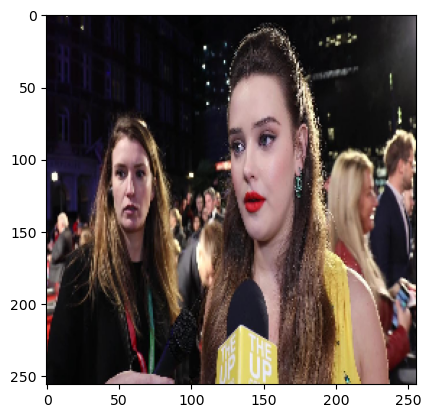

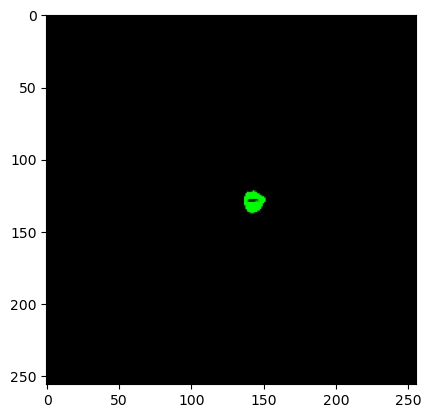

In [13]:
# Data loader

train_data_loader = DataLoader(train_data,batch_size=1,shuffle = True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle = False)

for img, mask in train_data_loader:
    print(img.shape)
    print(mask.shape)
    plt.imshow(np.array(img[0].permute(1,2,0),np.int32))
    plt.show()
    plt.imshow(mask[0].permute(1,2,0))
    plt.show()

    break

In [14]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std(), data[0].shape)

tensor(183.1251) tensor(66.4109) torch.Size([1, 3, 256, 256])


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
#!pip install segmentation_models_pytorch 

     ------------------------------------ 106.7/106.7 kB 885.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 549.1/549.1 kB 2.9 MB/s eta 0:00:00
     -------------------------------------- 58.8/58.8 kB 783.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 153.2/153.2 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 199.2/199.2 kB 1.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16465 sha256=2ee9012aa627b2fc4900cb2c955bdb014c9a67ff3d8b422217ffd991c3285cce
  Stored in directory: c:\users\tato\appdata\local\pip\cache\wheels\0e\cc\b2\49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl siz

In [19]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Linknet

model = Linknet(encoder_name='resnet50', 
               encoder_weights='imagenet', 
               classes=1,
               activation='sigmoid').to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Tato/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [21]:
import segmentation_models_pytorch.utils as smp_utils

In [22]:
# Optimizer, criterion, metric

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)

criterion = smp.utils.losses.DiceLoss()
metric = [smp.utils.metrics.IoU(),]

In [23]:
train_epoch = smp_utils.train.TrainEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         optimizer=optimizer, 
                                         device=device, 
                                         verbose=True)

valid_epoch = smp_utils.train.ValidEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         device=device)

In [ ]:
# Model

epochs = 3
max_score = 0
PATH_MODEL = './best_model.pth'
PATH_WEIGHTS = './best_weights.pth'
score_break_value = 0.9

for epoch in range(1,epochs+1):
    print(f'Current epoch - {epoch} from {epochs}')
    train_score = train_epoch.run(train_data_loader)
    valid_score = valid_epoch.run(test_data_loader)
    print(f'Next step.\n\n')
    
    if max_score < valid_score['iou_score']:
        max_score = valid_score['iou_score']
        torch.save(model.state_dict(), PATH_WEIGHTS)
        torch.save(model, PATH_MODEL)
        print('done')
        
    if max_score > score_break_value:
        break